In [1]:
from src.config import filepaths
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load stuff

eval_dir = filepaths['model_evals'] / "gnn"
kfold = 5
get_fps = lambda x : [
    eval_dir / f"{x}_hp_idx_split_{i+1}_of_{kfold}/predictions.csv"
    for i in range(kfold)
]

name_hp_idx = {
    'bag_of_molecules': 248,
    'rc_agg_r2': 94,
    'rc_agg_r3': 95,
    'rc_agg_r4': 256,
}

predictions = {}
for name, idx in name_hp_idx.items():
    tmp = []
    for fp in get_fps(idx):
        df = pd.read_csv(fp, sep='\t', index_col=0)
        df.sort_values(by="scores", ascending=True, inplace=True)
        df["Incorrect"] = abs(df["y_hat"] - df["y_true"])
        tmp.append(df)

    predictions[name] = pd.concat(tmp, axis=0)

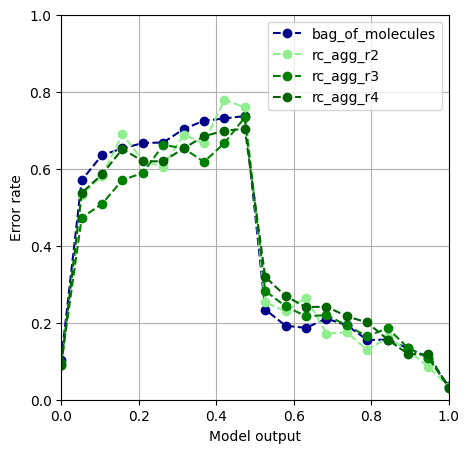

In [3]:
bin = 0.05
ep = bin * 1e-3
n_bins = int(1 / bin)
traces = {}
for name, pred in predictions.items():
    moving_ave = []
    for i in range(n_bins):
        lb, ub = i * bin, (i + 1) * (bin + ep)
        sel = (pred['scores'] >= lb) & (pred['scores'] < ub)
        pts = pred.loc[sel]
        error_rate = pts['Incorrect'].sum() / len(pts)
        moving_ave.append(error_rate)

    traces[name] = moving_ave

fig, ax =  plt.subplots(figsize=(5,5))
colors = ['darkblue', "lightgreen", "green", "darkgreen"]
x = np.linspace(0, 1, num=n_bins)
for i, (name, y) in enumerate(traces.items()):
    ax.plot(x, y, marker='o', ls='--', label=name, color=colors[i])
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
ax.grid()
ax.set_xlabel("Model output")
ax.set_ylabel("Error rate")
plt.show()
